In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score
from tqdm import tqdm
from utils import plot_book


In [85]:
df = pd.read_pickle("./results/results_random.pkl")
print(len(df[df["label"] == 1]))
print(len(df[df["label"] == 0]))
df[:100]


1016881
16055


,book,chapter,paragraph,label,logit_0,logit_1
0,3164.json,0,1,1,0.931343,0.391603
1,3164.json,0,2,1,0.881752,0.478187
2,3164.json,0,3,1,0.671587,0.124813
3,3164.json,0,4,1,0.758177,0.014503
4,3164.json,0,5,1,0.186959,0.500125
...,...,...,...,...,...,...
95,3164.json,0,96,1,0.372207,0.865086
96,3164.json,0,97,1,0.215018,0.128415
97,3164.json,0,98,1,0.273454,0.259642
98,3164.json,0,99,1,0.489625,0.535482


In [3]:
def f1(precision, recall):
    return 2*((precision*recall)/(precision+recall))

print(f1(0.83, 0.78))

0.8042236024844721


In [86]:
print(df["logit_0"].mean())

0.4999237656593323


In [87]:
print(df["paragraph"].median())

45.0


In [88]:
16055 / 1016881 * 100

1.5788474757616675

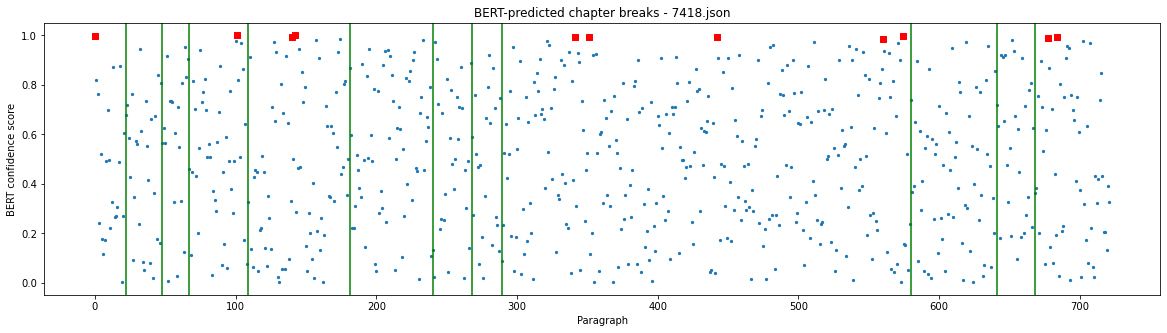

In [89]:
plot_book(df)

In [90]:
def add_predictions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["prediction"] = pd.Series([True for _ in range(len(df))])
    for book in tqdm(df["book"].unique()):
        book_df = df[df["book"] == book]
        predicted_chapters = book_df.sort_values("logit_0", ascending=False)[:len(book_df[book_df["label"] == 0])]
        for row in predicted_chapters.iterrows():
            df.loc[row[0], "prediction"] = False # chapter break is class 0

    return df

def calc_f1_score(df: pd.DataFrame) -> float:
    # class 0 (chapter break) is relevant for us
    return f1_score(df["label"].replace([1, 0], value=[False, True]), df["prediction"].replace([True, False], value=[False, True]))

def calc_windowdiff(df: pd.DataFrame) -> int:
    # adapted from nltk.metric.windowdiff
    wd = 0
    # chaptercaptor: k is set to half of the average true segment size
    k = round(len(df) / len(df[df["label"] == 0] * 2))
    for i in tqdm(range(len(df) - k)):
        gt = len(df.iloc[i:i+k+1].query("label == 0"))
        p = len(df.iloc[i:i+k+1].query("prediction == False"))
        wd += abs(gt - p)
    return wd / (len(df) - k)

def calc_pk(df: pd.DataFrame) -> float:
    # adapted from nltk.metrics
    err = 0
    # chaptercaptor: k is set to half of the average true segment size
    k = round(len(df) / len(df[df["label"] == 0] * 2))
    for i in tqdm(range(len(df) - k + 1)):
        r = len(df.iloc[i:i+k].query("label == 0"))
        h = len(df.iloc[i:i+k].query("prediction == False"))
        if r != h:
            err += 1
    return err / (len(df) - k + 1)

def calc_pk_wd(df: pd.DataFrame) -> float:
    wd = pk = 0
    k = round(len(df) / len(df[df["label"] == 0] * 2))
    for i in tqdm(range(len(df) - k)):
        gt = len(df.iloc[i:i+k+1].query("label == 0"))
        p = len(df.iloc[i:i+k+1].query("prediction == False"))
        wd += abs(gt - p)
        if gt != p:
            pk += 1

    return pk / (len(df) - k), wd / (len(df) - k)
        

In [91]:
pred_df = add_predictions(df)
pred_df[pred_df["prediction"] == False][:10]


100%|██████████| 799/799 [01:05<00:00, 12.25it/s]


,book,chapter,paragraph,label,logit_0,logit_1,prediction
6,3164.json,0,7,1,0.997852,0.469199,False
116,3164.json,1,16,1,0.997513,0.805339,False
376,3164.json,2,35,1,0.995709,0.919337,False
391,3164.json,2,50,1,0.995082,0.927822,False
395,3164.json,2,54,1,0.995789,0.976781,False
475,3164.json,3,2,1,0.995203,0.163614,False
948,3164.json,8,126,1,0.995350,0.520243,False
1003,3164.json,9,20,1,0.994795,0.948703,False
1061,3164.json,10,10,1,0.998204,0.985340,False
1156,3164.json,11,55,1,0.994755,0.222782,False


In [92]:
pred_df[pred_df["label"] == 0][:10]

,book,chapter,paragraph,label,logit_0,logit_1,prediction
100,3164.json,1,0,0,0.762920,0.465485,True
341,3164.json,2,0,0,0.072671,0.360470,True
473,3164.json,3,0,0,0.374525,0.461391,True
534,3164.json,4,0,0,0.323340,0.083531,True
566,3164.json,5,0,0,0.752490,0.075424,True
650,3164.json,6,0,0,0.453375,0.232250,True
775,3164.json,7,0,0,0.111246,0.253227,True
822,3164.json,8,0,0,0.708195,0.217994,True
983,3164.json,9,0,0,0.020272,0.948459,True
1051,3164.json,10,0,0,0.376260,0.756656,True


In [93]:
true_positive = pred_df.query("prediction == False and label == 0")
print(len(true_positive))
false_positive = pred_df.query("prediction == False and label == 1")
print(len(false_positive))
false_negative = pred_df.query("prediction == True and label == 0")
print(len(false_negative))
tp = len(true_positive)
fp = len(false_positive)
fn = len(false_negative)
print((2*tp) / (2*tp + fp + fn))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(2 * (precision * recall) / (precision + recall))

1094
14961
14961
0.06814076611647461
0.06814076611647461


In [94]:
print(calc_f1_score(pred_df))

0.06814076611647461


In [95]:
print(calc_f1_score(pred_df))
pk, wd = calc_pk_wd(pred_df)
print(pk)
print(wd)

0.06814076611647461


100%|██████████| 1032872/1032872 [34:40<00:00, 496.55it/s]

0.5624656298166666
0.7778272622357852


In [96]:
len(df["book"].unique())

799

In [97]:
test_df = df.copy()
test_df["label"]

0          1
1          1
2          1
3          1
4          1
          ..
1032931    1
1032932    1
1032933    1
1032934    1
1032935    1
Name: label, Length: 1032936, dtype: int64